In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
import scipy.io
from scipy import signal

import IPython

import os

PATH_IMG = "./imgs/"

print(os.getcwd())
print(os.listdir())

def cm_to_inch(value):
    return value/2.54

/home/andre/Documents/Git/STD_DCA0107/U1
['.ipynb_checkpoints', 'filtragem.ipynb', 'Projeto_Filtragem_remez.pdf', 'audio_ruidoso.wav', 'filtragem.pdf', 'imgs', 'parametros.jpg', 'exemplo.wav', 'audio_filtrado.wav']


# Espectograma e FFT do áudio

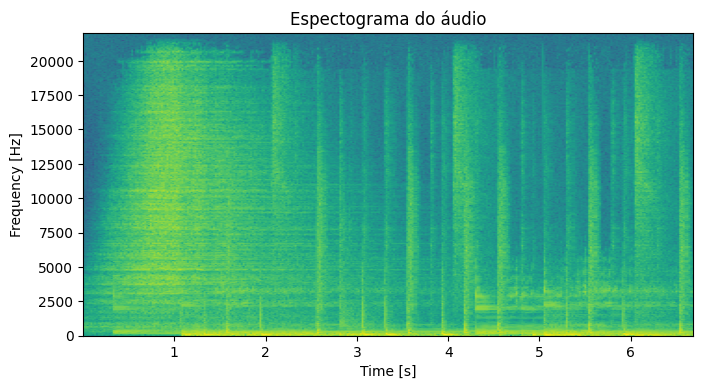

In [34]:
fs, data = scipy.io.wavfile.read("exemplo.wav")

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

spec, freqs, t, _ = plt.specgram(data, NFFT=1024, Fs=fs)

plt.title("Espectograma do áudio")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

plt.savefig(PATH_IMG+"espectograma_audio.png")

plt.show()

scipy.io.wavfile.write('exemplo.wav', fs, data.astype(np.int16))
IPython.display.Audio("exemplo.wav")

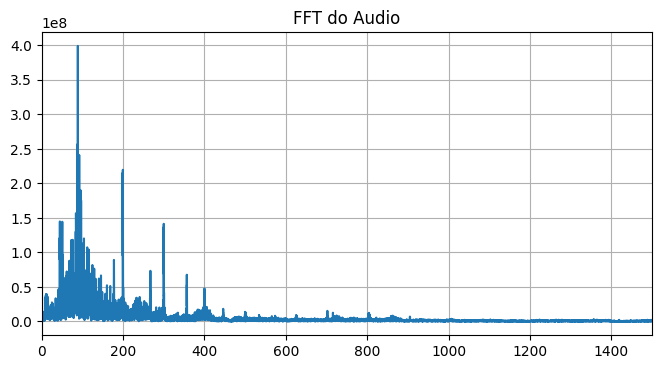

In [35]:
data_fft = fft(data)

Nfft = len(data_fft)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.title('FFT do Audio')
plt.plot(freqs, abs(data_fft[0:len(freqs)]))
plt.grid()

plt.xlim(0, 1500)

plt.savefig(PATH_IMG+'fft_audio.png')

plt.show()

# Adição do Ruído

$n(t) = \cos{(2\pi f_1 t)} + \cos{(2\pi f_2 t)}$

![Parametros](./parametros.jpg)

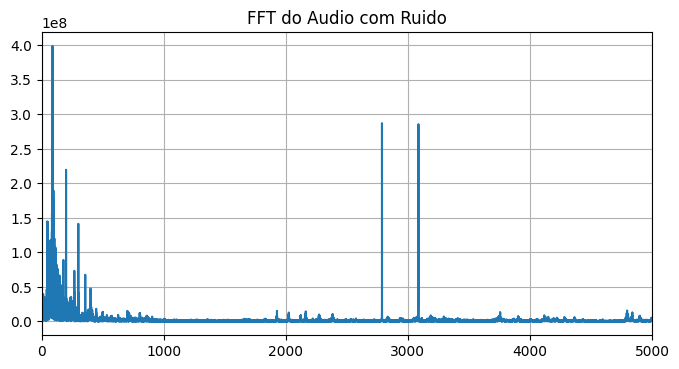

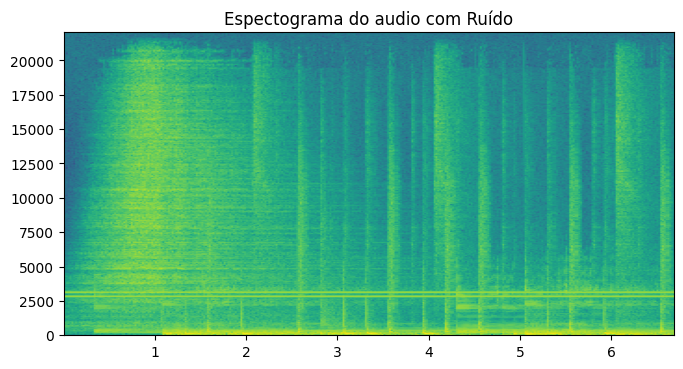

In [42]:
f1 = 2.8e3
f2 = 3.1e3

Amplitude = 2e3

time = np.linspace(0, t[len(t)-1], len(data))
n_t = Amplitude*np.cos(2 * np.pi * f1 * time) + Amplitude*np.cos(2 * np.pi * f2 * time)

data_ruido = data + n_t

data_ruido_fft = fft(data_ruido)

Nfft = len(data_ruido_fft)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.title('FFT do Audio com Ruido')
plt.plot(freqs, abs(data_ruido_fft[0:len(freqs)]))
plt.grid()

plt.xlim(0, 5000)

plt.savefig(PATH_IMG+"fft_audio_corrompido.png")

plt.show()

scipy.io.wavfile.write('audio_ruidoso.wav', fs, data_ruido.astype(np.int16))
IPython.display.Audio("audio_ruidoso.wav")

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)
plt.title("Espectograma do audio com Ruído")
Pxx, freqs, bins, im = plt.specgram(data_ruido, NFFT=1024, Fs=fs)
plt.savefig(PATH_IMG+"espectograma_audio_corrompido.png")

scipy.io.wavfile.write('audio_ruidoso.wav', fs, data_ruido.astype(np.int16))
IPython.display.Audio("audio_ruidoso.wav")

# Realizando a Filtragem

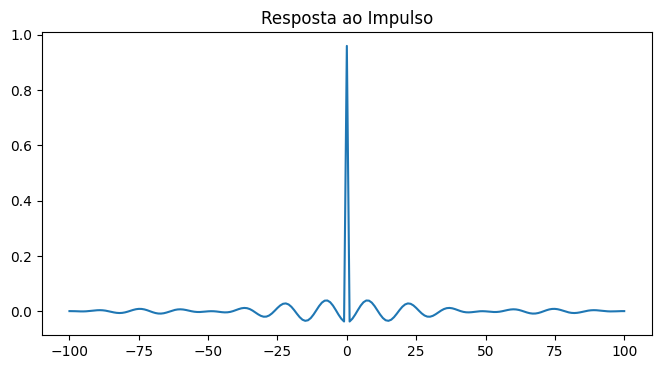

In [37]:
np.seterr(divide='ignore', invalid='ignore')

N1 = 100
n1 = np.arange(-N1,(N1+1),1)
NSamples = len(n1)

# fc = 2000
# wc = np.pi * fc/(fs/2)
# hlp = 1/(np.pi*n1)*(np.sin(wc*n1))
# hlp[n1==0] = wc / np.pi

wc1 = 2500*np.pi/(fs/2)
wc2 = 3400*np.pi/(fs/2)

hrf = 1/(np.pi*n1) * (np.sin(wc1*n1) - np.sin(wc2*n1)) 
hrf[n1 == 0] = 1 - (wc2 - wc1) / np.pi

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

# plt.scatter(n1,hlp)
plt.plot(n1,hrf)
plt.title('Resposta ao Impulso')

plt.savefig(PATH_IMG+"resposta_ao_impulso_filtro.png")

plt.show()


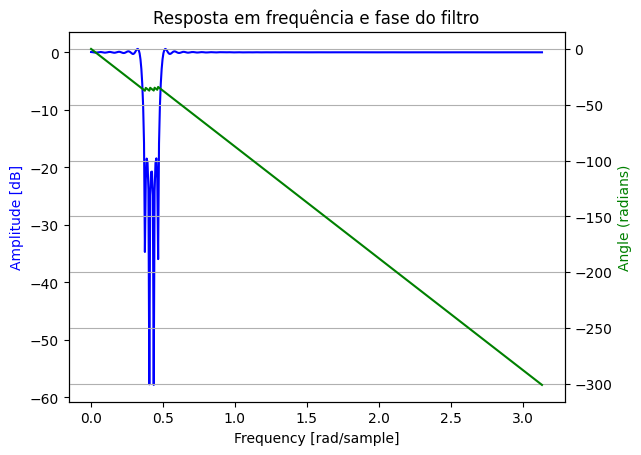

In [38]:
w, h = signal.freqz(hrf)
angles = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots()
ax1.set_title('Resposta em frequência e fase do filtro')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')

plt.savefig(PATH_IMG+"freqz_do_filtro.png")

plt.show()

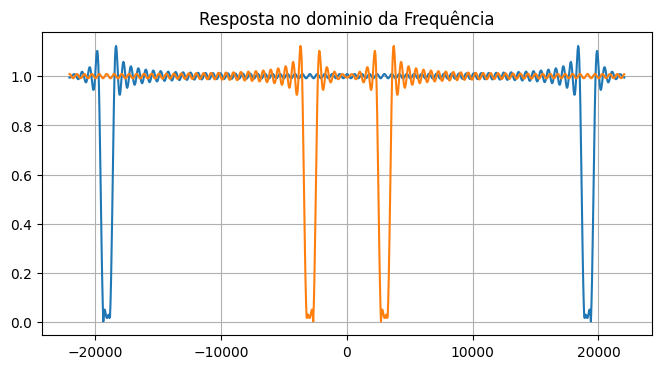

In [39]:
M = 150
M1 = -(M-1)/2
M2 = (M-1)/2

Idx = (n1>=M1) & (n1 <= M2)

w = np.ones(M)
h2 = np.array(hrf[Idx])

# atenuacao = 100
# beta = 0.1102 * (atenuacao - 8.7)
# w2 = signal.windows.kaiser(M, beta=beta)

Hw = fft(h2,1000)

freq_plot = np.linspace(-fs/2, fs/2, len(Hw))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.plot(freq_plot,abs(Hw))
plt.plot(freq_plot, abs(fftshift(Hw)))
plt.grid()

plt.title("Resposta no dominio da Frequência")
plt.savefig(PATH_IMG+"resposta_ao_impulso_frequencia.png")

plt.show()


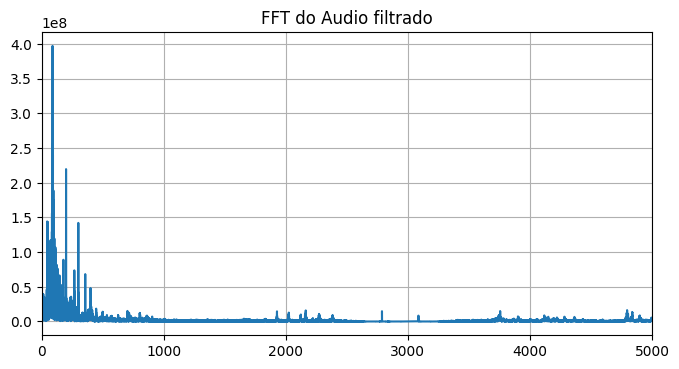

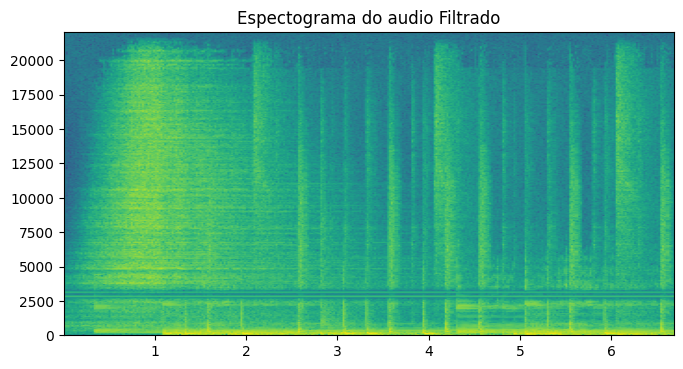

In [40]:
data_filtrado = signal.lfilter(h2, 1, data_ruido)
# data_filtrado = signal.lfilter(h2, 1, data_filtrado)

data_filtrado_fft = fft(data_filtrado)

Nfft = len(data_filtrado)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)
plt.title('FFT do Audio filtrado')
plt.plot(freqs, abs(data_filtrado_fft[0:len(freqs)]))
plt.grid()
plt.xlim(0, 5000)

plt.savefig(PATH_IMG+"fft_audio_filtrado.png")

plt.show()


figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)
plt.title("Espectograma do audio Filtrado")
Pxx, freqs, bins, im = plt.specgram(data_filtrado, NFFT=1024, Fs=fs)
plt.savefig(PATH_IMG+"espectograma_audio_filtrado.png")

scipy.io.wavfile.write('audio_filtrado.wav', fs, data_filtrado.astype(np.int16))
IPython.display.Audio("audio_filtrado.wav")